# Full Tutorial: Causal Machine Learning in Python (Feat. Uber's CausalML) by Matt Dancho
Video link: https://www.youtube.com/watch?v=qRDq3hN8IKI

## Quick Concepts:
- **CATE: Conditional Average Treatment Effect** \
- In normal machine learning, we make a prediction. But in CausalML, we make a prediction relative to the treatment \
- **Instead of Y_pred... We get Tau.** \
- Tau = CATE, and its a measurement of how much influence the treatment had on the observation \
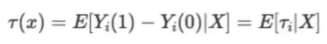

- CausalML provides a standard interface to convert any Sckit-Learn model, into a Causal ML model.
- In general it does this through Different types of Learners. There are several types of learners: \
a. S-Learner \
b. T-Learner \
c. X-Learner \
d. R-Learner \
All this learners actually framework for us to calculate Tau in a few different ways.
- Why do this? \
a. ML Models are more more flexible & accurate -> make it more challengint to measure the effectiveness of it \
b. Opens up interpretable Causal ML (SHAP) \
c. Allows us to get closer to the true effect from our Marketing Experiments \
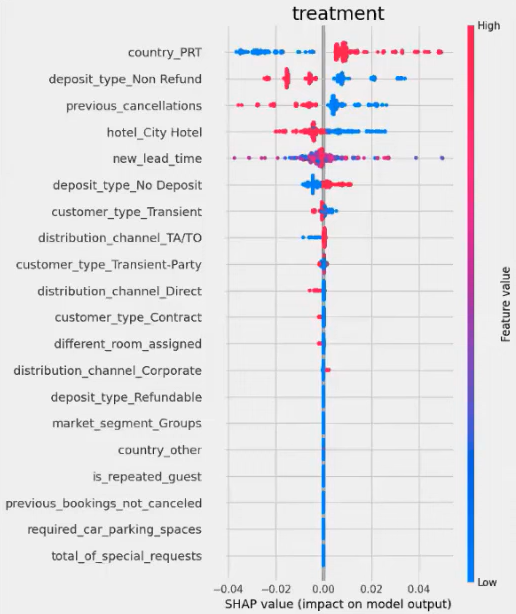
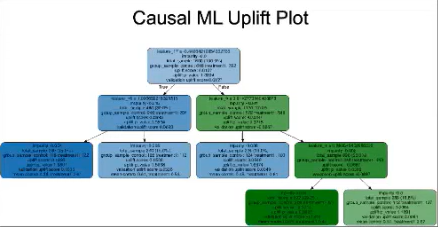

## Causal Inference (30-minutes Demo) on Hotel Marketing Business Case
Dataset Link: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

In [1]:
import pandas as pd
import numpy as np
import pytimetk as tk
from missingno import matrix

import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from sklearn.metrics import roc_auc_score


In [2]:
hotel_cancelation_raw_df = pd.read_csv('D:\Kerja\Merkle\causalml\hands_on\dataset\hotel_bookings.csv\hotel_bookings.csv')

In [3]:
hotel_cancelation_raw_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### Cost-Analysis

In [4]:
# How many people cancel?
cancellation_counts = hotel_cancelation_raw_df['is_canceled'].value_counts().reset_index()
cancellation_counts.columns = ['is_canceled', 'n']
cancellation_counts['prop'] = cancellation_counts['n'] / cancellation_counts['n'].sum()
cancellation_counts

,is_canceled,n,prop
0,0,75166,0.629584
1,1,44224,0.370416


In [5]:
# How much does this cost the hotel?
cost = 44224 * 200 * 3.4 # Average night cost at this hotel is $200 and average stay visit is 3.4 days
formatted_cost = "${:,.0f}".format(cost)
formatted_cost

'$30,072,320'

In [6]:
# 10% of the cost (if we solve only 10 %, it is this much!) -> understand the cost upfront
ten_percent_cost = 0.1 * cost
formatted_ten_percent_cost = "${:,.0f}".format(ten_percent_cost)
formatted_ten_percent_cost

'$3,007,232'

### Data Preprocessing

In [7]:
# 1. Basic Feature Engineering
hotel_cancellations_df = hotel_cancelation_raw_df.copy()

# Adding new features
hotel_cancellations_df['total_stay'] = hotel_cancellations_df['stays_in_weekend_nights'] + hotel_cancellations_df['stays_in_week_nights']
hotel_cancellations_df['total_guests'] = hotel_cancellations_df['adults'] + hotel_cancellations_df['children'] + hotel_cancellations_df['babies']
hotel_cancellations_df['different_room_assigned'] = (hotel_cancellations_df['reserved_room_type']!= hotel_cancellations_df['assigned_room_type']).astype(int)

In [8]:
# Dropping the original columns
hotel_cancellations_df.drop(
    columns=[
        'stays_in_weekend_nights',
        'stays_in_week_nights',
        'adults',
        'children',
        'babies',
        'reserved_room_type',
        'assigned_room_type'
    ],
    inplace=True
)

In [9]:
hotel_cancellations_df.glimpse()

<class 'pandas.core.frame.DataFrame'>: 119390 rows of 28 columns
hotel:                           object            ['Resort Hotel', 'Res ...
is_canceled:                     int64             [0, 0, 0, 0, 0, 0, 0, ...
lead_time:                       int64             [342, 737, 7, 13, 14, ...
arrival_date_year:               int64             [2015, 2015, 2015, 20 ...
arrival_date_month:              object            ['July', 'July', 'Jul ...
arrival_date_week_number:        int64             [27, 27, 27, 27, 27,  ...
arrival_date_day_of_month:       int64             [1, 1, 1, 1, 1, 1, 1, ...
meal:                            object            ['BB', 'BB', 'BB', 'B ...
country:                         object            ['PRT', 'PRT', 'GBR', ...
market_segment:                  object            ['Direct', 'Direct',  ...
distribution_channel:            object            ['Direct', 'Direct',  ...
is_repeated_guest:               int64             [0, 0, 0, 0, 0, 0, 0, ...
previous_ca

#### Fix Missing Value

<Axes: >

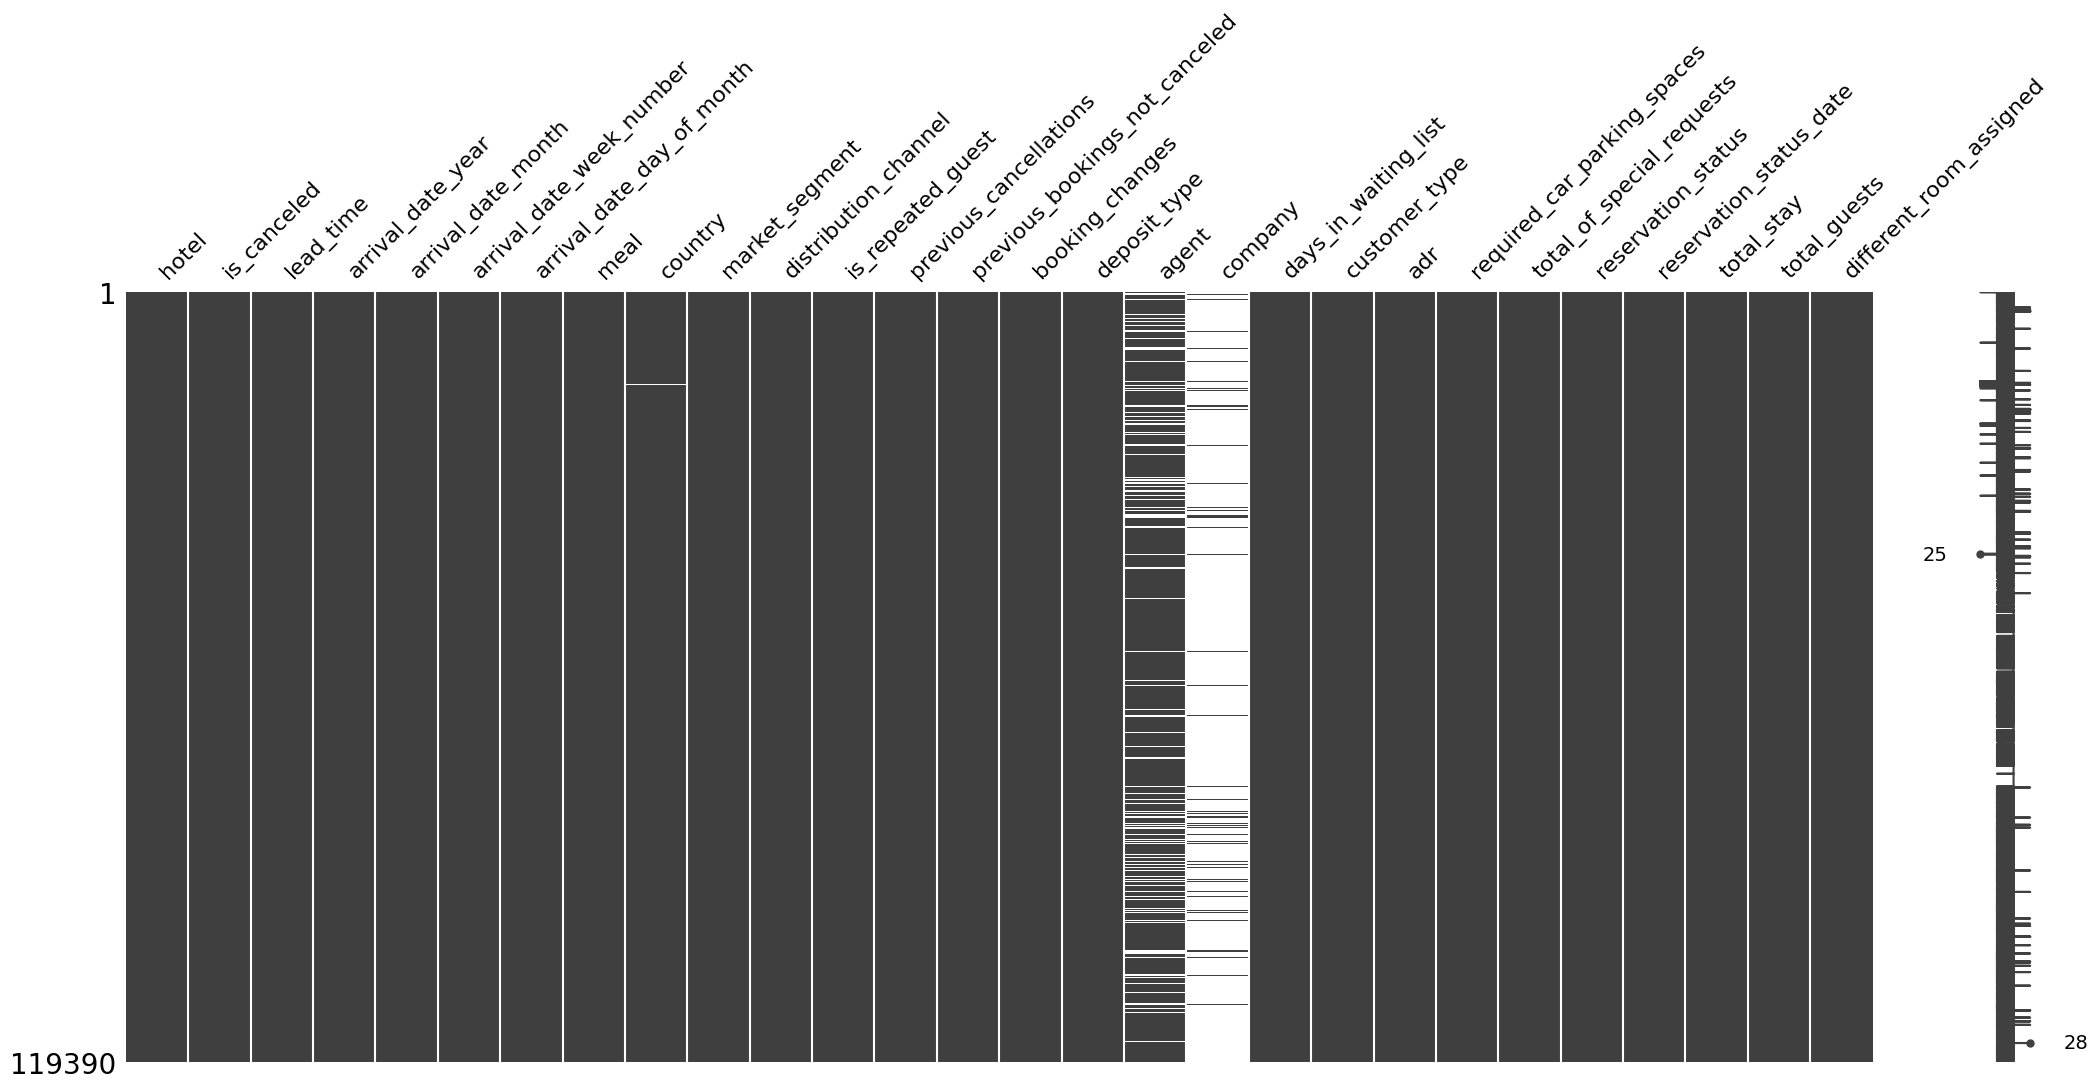

In [10]:
# Plot missing values
matrix(hotel_cancellations_df)

In [11]:
# Count by country with sorting
country_count = hotel_cancellations_df['country'].value_counts().reset_index()
country_count.columns = ['country', 'count']
country_count

,country,count
0,PRT,48590
1,GBR,12129
2,FRA,10415
3,ESP,8568
4,DEU,7287
...,...,...
172,DJI,1
173,BWA,1
174,HND,1
175,VGB,1


In [12]:
# Fix missing values and drop colimns
hotel_cancellations_df = hotel_cancellations_df.drop(columns=['company','agent'])
hotel_cancellations_df['country'].fillna('PRT')
hotel_cancellations_df.dropna(inplace=True)

#### Drop Unneded Columns

In [13]:
hotel_cancellations_df.glimpse()

<class 'pandas.core.frame.DataFrame'>: 118898 rows of 26 columns
hotel:                           object            ['Resort Hotel', 'Res ...
is_canceled:                     int64             [0, 0, 0, 0, 0, 0, 0, ...
lead_time:                       int64             [342, 737, 7, 13, 14, ...
arrival_date_year:               int64             [2015, 2015, 2015, 20 ...
arrival_date_month:              object            ['July', 'July', 'Jul ...
arrival_date_week_number:        int64             [27, 27, 27, 27, 27,  ...
arrival_date_day_of_month:       int64             [1, 1, 1, 1, 1, 1, 1, ...
meal:                            object            ['BB', 'BB', 'BB', 'B ...
country:                         object            ['PRT', 'PRT', 'GBR', ...
market_segment:                  object            ['Direct', 'Direct',  ...
distribution_channel:            object            ['Direct', 'Direct',  ...
is_repeated_guest:               int64             [0, 0, 0, 0, 0, 0, 0, ...
previous_ca

In [14]:
hotel_cancellations_df.drop(columns=['reservation_status_date'], inplace=True)

#### Initial Processing Complete

In [15]:
hotel_cancellations_df.glimpse()

<class 'pandas.core.frame.DataFrame'>: 118898 rows of 25 columns
hotel:                           object            ['Resort Hotel', 'Res ...
is_canceled:                     int64             [0, 0, 0, 0, 0, 0, 0, ...
lead_time:                       int64             [342, 737, 7, 13, 14, ...
arrival_date_year:               int64             [2015, 2015, 2015, 20 ...
arrival_date_month:              object            ['July', 'July', 'Jul ...
arrival_date_week_number:        int64             [27, 27, 27, 27, 27,  ...
arrival_date_day_of_month:       int64             [1, 1, 1, 1, 1, 1, 1, ...
meal:                            object            ['BB', 'BB', 'BB', 'B ...
country:                         object            ['PRT', 'PRT', 'GBR', ...
market_segment:                  object            ['Direct', 'Direct',  ...
distribution_channel:            object            ['Direct', 'Direct',  ...
is_repeated_guest:               int64             [0, 0, 0, 0, 0, 0, 0, ...
previous_ca

### 2.0 CORRELATION (LEVEL 1: ASSOCIATION)
Will use the new correlation funnel from pytimetk \
Firstly we need to assess what variables correlated with the cancellation, since the way we can get causation is by firstly investigate the correlation

In [16]:
# Binarize
df_binarized = hotel_cancellations_df.binarize()
df_binarized.glimpse()

<class 'pandas.core.frame.DataFrame'>: 118898 rows of 104 columns
lead_time__0.0_18.0:                     int32             [0, 0, 1, 1,  ...
lead_time__18.0_69.0:                    int32             [0, 0, 0, 0,  ...
lead_time__69.0_161.0:                   int32             [0, 0, 0, 0,  ...
lead_time__161.0_737.0:                  int32             [1, 1, 0, 0,  ...
arrival_date_week_number__1.0_16.0:      int32             [0, 0, 0, 0,  ...
arrival_date_week_number__16.0_28.0:     int32             [1, 1, 1, 1,  ...
arrival_date_week_number__28.0_38.0:     int32             [0, 0, 0, 0,  ...
arrival_date_week_number__38.0_53.0:     int32             [0, 0, 0, 0,  ...
arrival_date_day_of_month__1.0_8.0:      int32             [1, 1, 1, 1,  ...
arrival_date_day_of_month__8.0_16.0:     int32             [0, 0, 0, 0,  ...
arrival_date_day_of_month__16.0_23.0:    int32             [0, 0, 0, 0,  ...
arrival_date_day_of_month__23.0_31.0:    int32             [0, 0, 0, 0,  ...
adr__-6.4_

In [17]:
# Correlate
df_correlated = df_binarized.correlate(target="is_canceled__1")
df_correlated.head(10)

,feature,bin,correlation
24,is_canceled,0,-1.000000
100,reservation_status,Check-Out,-1.000000
25,is_canceled,1,1.000000
99,reservation_status,Canceled,0.978440
84,deposit_type,Non Refund,0.481349
83,deposit_type,No Deposit,-0.477791
58,country,PRT,0.335427
73,previous_cancellations,1,0.274504
72,previous_cancellations,0,-0.270873
0,lead_time,0.0_18.0,-0.268853


In [18]:
# Visualize
df_correlated.plot_correlation_funnel()

### 3.0 Subset Features that Describe the System

In [19]:
# Subset features
hotel_cancellations_subset_df = hotel_cancellations_df.drop(columns=['reservation_status'])

In [20]:
# Selecting specific columns
hotel_cancellations_subset_df = hotel_cancellations_subset_df[[
    'is_canceled','deposit_type','country','previous_cancellations',
    'lead_time', 'total_of_special_requests','different_room_assigned',
    'market_segment','required_car_parking_spaces','distribution_channel',
    'hotel','customer_type','previous_bookings_not_canceled','is_repeated_guest'
]]

In [21]:
# Creating new columns based on the 'country' column
hotel_cancellations_subset_df['country_PRT']=(hotel_cancellations_subset_df['country']=='PRT').astype(int)
hotel_cancellations_subset_df['country_other']=(hotel_cancellations_subset_df['country']!='PRT').astype(int)

In [22]:
# Dropping the original 'country' column
hotel_cancellations_subset_df.drop(columns='country', inplace=True)

In [23]:
hotel_cancellations_subset_df.glimpse()

<class 'pandas.core.frame.DataFrame'>: 118898 rows of 15 columns
is_canceled:                     category          [0, 0, 0, 0, 0, 0, 0, ...
deposit_type:                    object            ['No Deposit', 'No De ...
previous_cancellations:          category          [0, 0, 0, 0, 0, 0, 0, ...
lead_time:                       int64             [342, 737, 7, 13, 14, ...
total_of_special_requests:       category          [0, 0, 0, 0, 1, 1, 0, ...
different_room_assigned:         category          [0, 0, 1, 0, 0, 0, 0, ...
market_segment:                  object            ['Direct', 'Direct',  ...
required_car_parking_spaces:     category          [0, 0, 0, 0, 0, 0, 0, ...
distribution_channel:            object            ['Direct', 'Direct',  ...
hotel:                           object            ['Resort Hotel', 'Res ...
customer_type:                   object            ['Transient', 'Transi ...
previous_bookings_not_canceled:  category          [0, 0, 0, 0, 0, 0, 0, ...
is_repeated

### 4.0 CAUSAL HYPOTHESIS
Question 1: Do Groups tend to cancel more? (BAD - out of our control). Eventhou it showing positive correlation with cancellation. But imagine, if lets say we decline any group order, how many revenue loss will we suffer eventhou the cancellation is reduced? \
Question 2: Will reducing lead time reduce cancellations? (GOOD - within our control). It also show positive correlation in lead_time from 160.0 to 737.0

Thus, let's proceed with Question 2

#### Simple Logistic Model

In [24]:
# Preparing the data
lead_time_df = hotel_cancellations_subset_df[['is_canceled', 'lead_time']].copy()
lead_time_df['lead_time_binned'] = pd.qcut(lead_time_df['lead_time'], q=4, duplicates='drop')
lead_time_df

,is_canceled,lead_time,lead_time_binned
0,0,342,"(161.0, 737.0]"
1,0,737,"(161.0, 737.0]"
2,0,7,"(-0.001, 18.0]"
3,0,13,"(-0.001, 18.0]"
4,0,14,"(-0.001, 18.0]"
...,...,...,...
119385,0,23,"(18.0, 69.0]"
119386,0,102,"(69.0, 161.0]"
119387,0,34,"(18.0, 69.0]"
119388,0,109,"(69.0, 161.0]"


In [25]:
# One-hot encoding (with dropping the first category to avoid multicollinearity)
lead_time_dummies = pd.get_dummies(lead_time_df['lead_time_binned'], drop_first=True)
lead_time_dummies

,"(18.0, 69.0]","(69.0, 161.0]","(161.0, 737.0]"
0,False,False,True
1,False,False,True
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
119385,True,False,False
119386,False,True,False
119387,True,False,False
119388,False,True,False


In [26]:
X = lead_time_dummies.astype(float)
y = lead_time_df['is_canceled'].astype(float)

In [27]:
X.head()

,"(18.0, 69.0]","(69.0, 161.0]","(161.0, 737.0]"
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [28]:
# Add a constant to the model (intercept)
X = sm.add_constant(X)

In [29]:
X.head()

,const,"(18.0, 69.0]","(69.0, 161.0]","(161.0, 737.0]"
0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [30]:
# Fit the model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.609785
         Iterations 6


In [31]:
# Print the summary
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:               118898
Model:                          Logit   Df Residuals:                   118894
Method:                           MLE   Df Model:                            3
Date:                Sun, 09 Jun 2024   Pseudo R-squ.:                 0.07562
Time:                        16:39:13   Log-Likelihood:                -72502.
converged:                       True   LL-Null:                       -78434.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.7570      0.016   -107.606      0.000      -1.789      -1.725
(18.0, 69.0]       1.1773      0.020     57.901      0.000       1.137       1.217
(69.0, 161.0]      1.4642      0.020

In [32]:
# Logistic Regression produces Log-odds
print("160+ days: "+ np.exp(1.98).astype(str)) # 160+ days -> 160+ days -> 7.2X wisk of cancellation
print("69 to 160 days: "+np.exp(1.46).astype(str)) # 69-160 days -> 4.3X risk
print("18 to 69 days: "+np.exp(1.18).astype(str)) # 18-69 days -> 3.25X risk

160+ days: 7.242742985161012
69 to 160 days: 4.305959528345206
18 to 69 days: 3.2543742028896707


Here, we see that the longer the lead time, the more likely guests will cancel their booking. But the story does not end here, since we see that the Pseudo R-squuare is 0.07562 (ranged from 0 to 1 and we want it to be closer to 1.0). This value represent the variant explained inside the logistic regression model.

Thus the problem were, this is not reality, lead time isn't the only thing affecting cancellations

### 5.0 CONSIDERING CONFOUNDERS
We don't know the full story yet, so we need to approximate it with a more accurate model

In [33]:
# Preprocessing
df = hotel_cancellations_subset_df.copy()
df['lead_time'] = pd.qcut(df['lead_time'], q=4, duplicates='drop')
df.glimpse()

<class 'pandas.core.frame.DataFrame'>: 118898 rows of 15 columns
is_canceled:                     category          [0, 0, 0, 0, 0, 0, 0, ...
deposit_type:                    object            ['No Deposit', 'No De ...
previous_cancellations:          category          [0, 0, 0, 0, 0, 0, 0, ...
lead_time:                       category          [Interval(161.0, 737. ...
total_of_special_requests:       category          [0, 0, 0, 0, 1, 1, 0, ...
different_room_assigned:         category          [0, 0, 1, 0, 0, 0, 0, ...
market_segment:                  object            ['Direct', 'Direct',  ...
required_car_parking_spaces:     category          [0, 0, 0, 0, 0, 0, 0, ...
distribution_channel:            object            ['Direct', 'Direct',  ...
hotel:                           object            ['Resort Hotel', 'Res ...
customer_type:                   object            ['Transient', 'Transi ...
previous_bookings_not_canceled:  category          [0, 0, 0, 0, 0, 0, 0, ...
is_repeated

In [34]:
df = pd.get_dummies(df, drop_first=True)
df.glimpse()

<class 'pandas.core.frame.DataFrame'>: 118898 rows of 119 columns
country_PRT:                        int32             [1, 1, 0, 0, 0, 0, ...
country_other:                      int32             [0, 0, 1, 1, 1, 1, ...
is_canceled_1:                      bool              [False, False, Fal ...
deposit_type_Non Refund:            bool              [False, False, Fal ...
deposit_type_Refundable:            bool              [False, False, Fal ...
previous_cancellations_1:           bool              [False, False, Fal ...
previous_cancellations_2:           bool              [False, False, Fal ...
previous_cancellations_3:           bool              [False, False, Fal ...
previous_cancellations_4:           bool              [False, False, Fal ...
previous_cancellations_5:           bool              [False, False, Fal ...
previous_cancellations_6:           bool              [False, False, Fal ...
previous_cancellations_11:          bool              [False, False, Fal ...
previous_c

In [35]:
# Convert all dummy columns to int
for column in df.columns:
    if df[column].dtype == 'bool':
        df[column] = df[column].astype(int)

df.glimpse()

<class 'pandas.core.frame.DataFrame'>: 118898 rows of 119 columns
country_PRT:                        int32             [1, 1, 0, 0, 0, 0, ...
country_other:                      int32             [0, 0, 1, 1, 1, 1, ...
is_canceled_1:                      int32             [0, 0, 0, 0, 0, 0, ...
deposit_type_Non Refund:            int32             [0, 0, 0, 0, 0, 0, ...
deposit_type_Refundable:            int32             [0, 0, 0, 0, 0, 0, ...
previous_cancellations_1:           int32             [0, 0, 0, 0, 0, 0, ...
previous_cancellations_2:           int32             [0, 0, 0, 0, 0, 0, ...
previous_cancellations_3:           int32             [0, 0, 0, 0, 0, 0, ...
previous_cancellations_4:           int32             [0, 0, 0, 0, 0, 0, ...
previous_cancellations_5:           int32             [0, 0, 0, 0, 0, 0, ...
previous_cancellations_6:           int32             [0, 0, 0, 0, 0, 0, ...
previous_cancellations_11:          int32             [0, 0, 0, 0, 0, 0, ...
previous_c

In [36]:
# Train/Test split using pandas
train_df = df.sample(frac=0.8, random_state=123)
test_df = df.drop(train_df.index)

In [37]:
# Fit Model with L1 Penalty (Lasso)
X_train = train_df.drop(columns=['is_canceled_1'])
y_train = train_df['is_canceled_1']

model = GLM(y_train, sm.add_constant(X_train), family=Binomial(), link=logit())
result = model.fit_regularized(method='elastic_net', alpha=0.01, L1_wt=1.0) # L1_wt=1.0 for Lasso

In [38]:
# Is the model any good?

# Add a constant to the test data
X_test = sm.add_constant(test_df.drop(columns=['is_canceled_1']))
y_test = test_df['is_canceled_1']

In [39]:
# Make predictions
predicted_probabilities = result.predict(X_test)

In [40]:
# Calculate the ROC AUC
roc_auc = roc_auc_score(y_test, predicted_probabilities)
roc_auc

0.8618983535550439

In [41]:
# Print the summary
pd.DataFrame(result.params)

,0
const,-0.151362
country_PRT,0.000000
country_other,-1.134760
deposit_type_Non Refund,2.313810
deposit_type_Refundable,0.000000
...,...
previous_bookings_not_canceled_69,0.000000
previous_bookings_not_canceled_70,0.000000
previous_bookings_not_canceled_71,0.000000
previous_bookings_not_canceled_72,0.000000


In [43]:
print("lead time 160+ days: "+np.exp(0.4).astype(str)) # 1.5X risk of cancellation for each additional lead time bin
print("lead time 69 to 160 days: "+np.exp(0.12).astype(str)) # 1.2X risk of cancellation for each additiona lead time bin
print("lead time 18 to 69 days: "+np.exp(0).astype(str)) # 1X wisk of cancellation for each additional lead time bin

lead time 160+ days: 1.4918246976412703
lead time 69 to 160 days: 1.1274968515793757
lead time 18 to 69 days: 1.0


Here, we can get better result model that shows that lead time is indeed increase the risk of cancellation, but not as extreme as before \
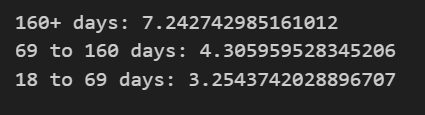

### Next Steps
- We have a model that predicts hotel cancellations
- We used this model to understand the system
- We can develop an experiment that tests reduction in cancellation by influencing lead time
- We can use the model to estimate the pre-treatment effect of reducing lead time

Continue on 46:42